In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torchvision
from torchvision import datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from pathlib import Path
from sklearn.model_selection import train_test_split
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
torchvision.__version__, torch.__version__ # ('0.11.1+cu111', '1.10.0+cu111')

('0.11.2+cu111', '1.10.1+cu111')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
class CFG:

  # epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  BATCH_SIZE = 35
  N_EPOCHS = 50                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [6]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [7]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

GridMask

In [8]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMax


In [9]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image


In [10]:

import albumentations
import albumentations.pytorch

In [11]:
transforms_train = albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.OneOf([
         GridMask(num_grid=1, mode=0.2, rotate=0),
        GridMask(num_grid=2, mode=0.3, rotate=0),
    ], p=0.3),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    # RandomAugMix(severity=3, width=3, alpha=1., p=1.),
    albumentations.pytorch.ToTensorV2()
])

test_transformer=albumentations.Compose([
    albumentations.Resize(224,224),
    albumentations.pytorch.ToTensorV2()
    # RandomAugMix(severity=4, width=3, alpha=1.0, p=0.2)
])

In [12]:
import cv2



In [13]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [14]:
train=Dataset(train_dir,transforms_train)
test=Dataset(test_dir,test_transformer)
Dataset(Base_dir,test_transformer)

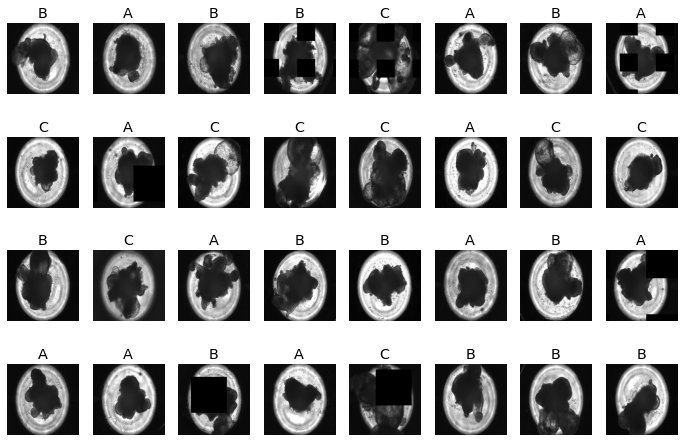

In [15]:
train_loader = torch.utils.data.DataLoader(dataset =train, batch_size = 36, shuffle=False)
samples, label = iter(train_loader).next()
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

ad = {0:'A', 1:'B',2:'C'}

for num, sample in enumerate(samples[:32]):
    plt.subplot(4,8,num+1)
    plt.title(ad[label[num].item()])
    plt.axis('off')
    sample = sample.cpu()
    plt.imshow(sample.permute(1, 2, 0))

In [16]:
from torchtoolbox.transform import Cutout

In [17]:
# transformations1 = transforms.Compose([
#     transforms.Resize(CFG.img_size),
#     transforms.RandomHorizontalFlip(p=1),
#     # transforms.RandomErasing(),
#     transforms.ToTensor(),
# #     transforms.Normalize(mean,std)

# ])
# train_augumented1 = Dataset(train_dir,transformations1)
# transformations2 =transforms.Compose([
#     transforms.ToTensor(),
#     
# ])

# train_augumented2 = Dataset(train_dir,transformations2)
# transformations3 = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     Cutout(),
#     transforms.RandomVerticalFlip(p=1),
#     transforms.ColorJitter(0.4, 0.4, 0.4),
#     transforms.ToTensor(),
# ])
# train_augumented3 = Dataset(train_dir,transformations3)

In [18]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [19]:
# train = ConcatDataset([train1, train_augumented1,train_augumented3])

In [20]:
train_loader=DataLoader(train,batch_size=CFG.BATCH_SIZE,num_workers=16)
# val_loader=DataLoader(val,batch_size=CFG.BATCH_SIZE,num_workers=25)
test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=16)


In [21]:
torch.backends.cudnn.benchmark = True

In [22]:
### Obtained from Paper ###
# Configs taken from 
# https://github.com/leondgarse/keras_efficientnet_v2/blob/main/keras_efficientnet_v2/efficientnet_v2.py
# convs parameter is which type of block to use, maps to `layer_map`
# 6 models are supported, more are coming soon.
CONFIGS = {
    "b0": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [1, 2, 2, 3, 5, 8],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_b0",
    },
    "b1": {
        "widths": [32, 16, 32, 48, 96, 112, 192],
        "depths": [2, 3, 3, 4, 6, 9],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs":[0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_b1",
    },
    "b2": {
        "widths": [32, 16, 32, 56, 104, 120, 208],
        "depths": [2, 3, 3, 4, 6, 10],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1408,
        "timm_weights":"tf_efficientnetv2_b2",
    },
    "s": {
        "widths": [24, 24, 48, 64, 128, 160, 256],
        "depths": [2, 4, 4, 6, 9, 15],
        "strides": [1, 2, 2, 2, 1, 2],
        "convs": [0, 1, 1, 2, 3, 3],
        "output_conv_size": 1280,
        "timm_weights": "tf_efficientnetv2_s"
    },
    "m": {
        "widths": [24, 24, 48, 80, 160, 176, 304, 512],
        "depths": [3, 5, 5, 7, 14, 18, 5],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_m",
    },
    "l": {
        "widths": [32, 32, 64, 96, 192, 224, 384, 640],
        "depths": [4, 7, 7, 10, 19, 25, 7],
        "strides": [1, 2, 2, 2, 1, 2, 1],
        "convs": [0, 1, 1, 2, 3, 3, 3],
        "output_conv_size": 1280,
        "timm_weights":"tf_efficientnetv2_l",
    }
}

In [23]:
def conv_block(in_channels, out_channels, kernel_size=3, 
               stride=1, padding=1, groups=1,
               bias=False, bn=True, act = True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                  padding=padding, groups=groups, bias=bias),
        nn.BatchNorm2d(out_channels) if bn else nn.Identity(),
        nn.SiLU() if act else nn.Identity()
    ]
    return nn.Sequential(*layers)

In [24]:
4//1

4

In [25]:
class SEBlock(nn.Module):
    def __init__(self, c, r=24):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveMaxPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(c, c // r, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(c // r, c, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        s = self.squeeze(x)
        e = self.excitation(s)
        return x * e

In [26]:
class MBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(MBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = nn.Identity() if expansion == 1 else conv_block(n_in, expanded, kernel_size=1, padding=0)
        self.depthwise = conv_block(expanded, expanded, kernel_size=kernel_size, 
                                    stride=stride, padding=padding, groups=expanded)
        self.se = SEBlock(expanded, r=4 * expansion)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [27]:
class FusedMBConv(nn.Module):
    def __init__(self, n_in, n_out, expansion, kernel_size=3, stride=1, r=24, dropout=0.1):
        super(FusedMBConv, self).__init__()
        self.skip_connection = (n_in == n_out) and (stride == 1)
        padding = (kernel_size-1)//2
        expanded = expansion*n_in
        
        self.expand_pw = conv_block(n_in, expanded, kernel_size=3, stride=stride, padding=1)
        self.reduce_pw = conv_block(expanded, n_out, kernel_size=1, padding=0, act=False)
        
        if expansion == 1:
            self.reduce_pw = nn.Identity() # for consistency with timm implementation
            self.expand_pw = conv_block(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        x = self.expand_pw(x)
        x = self.reduce_pw(x)
        if self.skip_connection:
            x = self.dropout(x)
            x = x + residual
        return x

In [28]:
def mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def mbconv6(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return MBConv(n_in, n_out, 6, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv1(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 1, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
def fused_mbconv4(n_in, n_out, kernel_size=3, stride=1, r=24, dropout=0.1):
    return FusedMBConv(n_in, n_out, 4, kernel_size=kernel_size, stride=stride, r=r, dropout=dropout)
layers_map = [fused_mbconv1, fused_mbconv4, mbconv4, mbconv6]

In [29]:
def create_stage(n_in, n_out, num_layers, layer=mbconv6, 
                 kernel_size=3, stride=1, r=24, ps=0):
    layers = [layer(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, dropout=ps)]
    layers += [layer(n_out, n_out, kernel_size=kernel_size,
                        r=r, dropout=ps) for _ in range(num_layers-1)]
    return nn.Sequential(*layers)

In [30]:
class EfficientNetV2(nn.Module):
    """
    Generic EfficientNet V2 Class.
    """
    def __init__(self, cfg, n_classes=3):
        super(EfficientNetV2, self).__init__()
        self.cfg = cfg
        self.n_classes = n_classes
        widths, depths, strides, convs = cfg['widths'],cfg['depths'],cfg['strides'],cfg['convs']
        outconv_size = cfg['output_conv_size']
        
        stages = [conv_block(3, widths[0], stride=2, padding=1)]
        for i in range(len(depths)):
            stages.append(create_stage(widths[i], widths[i + 1], depths[i], layer=layers_map[convs[i]], 
                        stride=strides[i], r=4 if i ==0 else 24, ps=0))

        self.features = nn.Sequential(*stages)
        self.pre = conv_block(widths[-1], outconv_size, kernel_size=1, padding=0)
        self.pool_flatten = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten())
        self.head = nn.Sequential(
            nn.Linear(outconv_size, n_classes)
        )
            
    def forward(self, x):
        x = self.features(x)
        x = self.pre(x)
        x = self.pool_flatten(x)
        x = self.head(x)
        return x

In [31]:
def efficientnetv2_b0(n_classes=3):
    return EfficientNetV2(CONFIGS['b0'], n_classes=n_classes)
def efficientnetv2_b1(n_classes=3):
    return EfficientNetV2(CONFIGS['b1'], n_classes=n_classes)
def efficientnetv2_b2(n_classes=3):
    return EfficientNetV2(CONFIGS['b2'], n_classes=n_classes)
def efficientnetv2_s(n_classes=3):
    return EfficientNetV2(CONFIGS['s'], n_classes=n_classes)
def efficientnetv2_m(n_classes=3):
    return EfficientNetV2(CONFIGS['m'], n_classes=n_classes)
def efficientnetv2_l(n_classes=3):
    return EfficientNetV2(CONFIGS['l'], n_classes=n_classes)

In [32]:
classes=['A','B','C']

In [33]:
def load_timm_weights(model):
    url = model.cfg.get("timm_weights")
    timm_model = timm.create_model(url, pretrained=True, num_classes=len(classes))
    params = nn.utils.parameters_to_vector(timm_model.parameters())
    nn.utils.vector_to_parameters(params, model.parameters())

In [34]:
model = efficientnetv2_s(n_classes=len(classes))
load_timm_weights(model)

In [35]:
for param in model.parameters():
    param.requires_grad = False
    
n_inputs = model.head[0].in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs,512),
    nn.SiLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
print(model.head)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=3, bias=True)
)


In [36]:
inp = torch.randn(1, 3, 224, 224)
model(inp).shape

torch.Size([1, 3])

In [37]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [38]:
print_size_of_model(model)

Size (MB): 84.158691


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [40]:
from torch import nn, optim

In [41]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
# optimizer = optim.SGD(model.parameters(), 0.01,
#                                 momentum=0.9,
#                                 weight_decay=1e-5)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

In [42]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [43]:
from tqdm import tqdm
import time
import copy

In [44]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [45]:
train_data_len=len(train)
# valid_data_len=len(val)
test_data_len=len(test)

In [46]:
print(len(train_loader))
# print(len(val_loader))
print(len(test_loader))
print(train_data_len, test_data_len,)

35
9
1200 300


In [47]:
from cmath import inf
def train_model(model, criterion, optimizer, scheduler, train_loader,val_loader,train_dataset,valid_dataset,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = inf
    dataloaders = {
        "train":train_loader,
        "val": val_loader
    }
    dataset_sizes = {
        "train":len(train_dataset),
        "val": len(valid_dataset)
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
# def train_model(model, criterion, optimizer, scheduler, train_loader,val_loader,train_dataset,valid_dataset,num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
#     dataloaders = {
#         "train":train_loader,
#         "val": val_loader
#     }
#     dataset_sizes = {
#         "train":len(train_dataset),
#         "val": len(valid_dataset)
#     }

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.x_batch = x_batch.float()
#             for inputs, labels in tqdm(dataloaders[phase]):
#                 inputs = inputs.to(device).float()
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
#             if phase == 'train':
#                 training_history['accuracy'].append(epoch_acc)
#                 training_history['loss'].append(epoch_loss)
#             elif phase == 'val':
#                 validation_history['accuracy'].append(epoch_acc)
#                 validation_history['loss'].append(epoch_loss)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [49]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.BATCH_SIZE,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [50]:
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [51]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform:
            res = self.transform(image=img)
            img = res['image']
        else:
            img = img

        return (img, label)

In [52]:
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(model.parameters(), lr=0.00015)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)
train_directory=np.array(train_dir)

In [53]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
models=[]
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        gc.collect()
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        print(len(train_dir))
        

960
960
960
960
960


In [54]:
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
models=[]
for fold_idx, (train_num, valid_num) in enumerate(kf.split(train_directory)):
        gc.collect()
        train_dir=train_directory[train_num].tolist()
        valid_dir=train_directory[valid_num].tolist()
        train_dataset = Dataset(train_dir,transforms_train)
        train_loader = DataLoader(train_dataset, CFG.BATCH_SIZE, shuffle=True,num_workers=16)
        valid_dataset = Dataset(valid_dir,test_transformer)
        val_loader = DataLoader(valid_dataset, CFG.BATCH_SIZE, shuffle=False,num_workers=16)

        model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,train_loader,val_loader,
                        train_dataset,valid_dataset,num_epochs=CFG.N_EPOCHS) # 15 total
        dir_path='./weights2/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        torch.save(model_ft.state_dict(), f'./weights2/model_5e_{fold_idx}.pth')
        print(f'fold{fold_idx+1} finished!')
        gc.collect()

Epoch 0/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.81it/s]


train Loss: 1.0092 Acc: 0.4813


100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


val Loss: 3.7540 Acc: 0.3292
Epoch 1/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.54it/s]


train Loss: 0.8080 Acc: 0.6083


100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


val Loss: 0.8687 Acc: 0.5542
Epoch 2/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.63it/s]


train Loss: 0.7149 Acc: 0.6531


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


val Loss: 0.7138 Acc: 0.6833
Epoch 3/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.61it/s]


train Loss: 0.6449 Acc: 0.6813


100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


val Loss: 0.6673 Acc: 0.7083
Epoch 4/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.60it/s]


train Loss: 0.6125 Acc: 0.7271


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


val Loss: 0.6620 Acc: 0.7083
Epoch 5/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.57it/s]


train Loss: 0.5731 Acc: 0.7375


100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


val Loss: 0.6626 Acc: 0.7125
Epoch 6/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.64it/s]


train Loss: 0.5414 Acc: 0.7635


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


val Loss: 0.6711 Acc: 0.7167
Epoch 7/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.62it/s]


train Loss: 0.5182 Acc: 0.7708


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


val Loss: 0.6757 Acc: 0.6917
Epoch 8/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.61it/s]


train Loss: 0.4919 Acc: 0.7865


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


val Loss: 0.6385 Acc: 0.7458
Epoch 9/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.58it/s]


train Loss: 0.4302 Acc: 0.8260


100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


val Loss: 0.6743 Acc: 0.7375
Epoch 10/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.58it/s]


train Loss: 0.4109 Acc: 0.8281


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


val Loss: 0.7267 Acc: 0.6708
Epoch 11/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.60it/s]


train Loss: 0.3975 Acc: 0.8375


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


val Loss: 0.7148 Acc: 0.7292
Epoch 12/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.58it/s]


train Loss: 0.4163 Acc: 0.8208


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


val Loss: 0.7696 Acc: 0.7083
Epoch 13/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.60it/s]


train Loss: 0.3069 Acc: 0.8812


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


val Loss: 0.7570 Acc: 0.7333
Epoch 14/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.55it/s]


train Loss: 0.2661 Acc: 0.8875


100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


val Loss: 0.7375 Acc: 0.7083
Epoch 15/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.53it/s]


train Loss: 0.3052 Acc: 0.8760


100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


val Loss: 0.7352 Acc: 0.7292
Epoch 16/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.57it/s]


train Loss: 0.1920 Acc: 0.9229


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


val Loss: 0.8572 Acc: 0.6792
Epoch 17/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.56it/s]


train Loss: 0.2380 Acc: 0.9031


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


val Loss: 0.8209 Acc: 0.7292
Epoch 18/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.58it/s]


train Loss: 0.2646 Acc: 0.8958


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.9391 Acc: 0.6917
Epoch 19/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.51it/s]


train Loss: 0.1941 Acc: 0.9260


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.8148 Acc: 0.6917
Epoch 20/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.52it/s]


train Loss: 0.1605 Acc: 0.9323


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 0.8246 Acc: 0.7083
Epoch 21/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.42it/s]


train Loss: 0.1789 Acc: 0.9375


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 1.0187 Acc: 0.6833
Epoch 22/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.55it/s]


train Loss: 0.1800 Acc: 0.9333


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


val Loss: 0.8663 Acc: 0.7250
Epoch 23/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.37it/s]


train Loss: 0.1853 Acc: 0.9313


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


val Loss: 0.8308 Acc: 0.7167
Epoch 24/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.26it/s]


train Loss: 0.1595 Acc: 0.9437


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.8488 Acc: 0.7083
Epoch 25/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.12it/s]


train Loss: 0.1355 Acc: 0.9448


100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


val Loss: 0.9713 Acc: 0.7083
Epoch 26/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.1263 Acc: 0.9490


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


val Loss: 1.1682 Acc: 0.6958
Epoch 27/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.62it/s]


train Loss: 0.1607 Acc: 0.9375


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 0.9796 Acc: 0.7167
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.1154 Acc: 0.9479


100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


val Loss: 0.8600 Acc: 0.7333
Epoch 29/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.83it/s]


train Loss: 0.1021 Acc: 0.9573


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.8764 Acc: 0.7333
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.24it/s]


train Loss: 0.1043 Acc: 0.9656


100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


val Loss: 1.0232 Acc: 0.7083
Epoch 31/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.84it/s]


train Loss: 0.1346 Acc: 0.9510


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


val Loss: 1.1293 Acc: 0.7083
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.0954 Acc: 0.9604


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 1.0930 Acc: 0.7083
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


train Loss: 0.0835 Acc: 0.9677


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 1.0753 Acc: 0.7292
Epoch 34/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


train Loss: 0.1119 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 1.1283 Acc: 0.7042
Epoch 35/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.95it/s]


train Loss: 0.0984 Acc: 0.9615


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


val Loss: 1.0981 Acc: 0.6958
Epoch 36/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.87it/s]


train Loss: 0.0875 Acc: 0.9708


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


val Loss: 1.0857 Acc: 0.6792
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


train Loss: 0.0872 Acc: 0.9677


100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


val Loss: 1.0910 Acc: 0.7167
Epoch 38/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.63it/s]


train Loss: 0.1121 Acc: 0.9510


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


val Loss: 1.1093 Acc: 0.6958
Epoch 39/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.82it/s]


train Loss: 0.1041 Acc: 0.9573


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.9225 Acc: 0.7292
Epoch 40/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.83it/s]


train Loss: 0.0732 Acc: 0.9750


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 1.0514 Acc: 0.6917
Epoch 41/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.81it/s]


train Loss: 0.0937 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 1.0981 Acc: 0.6958
Epoch 42/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.79it/s]


train Loss: 0.0919 Acc: 0.9677


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 1.1688 Acc: 0.6833
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


train Loss: 0.0819 Acc: 0.9708


100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


val Loss: 1.0290 Acc: 0.7000
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


train Loss: 0.0823 Acc: 0.9698


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 1.0511 Acc: 0.7125
Epoch 45/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.83it/s]


train Loss: 0.0633 Acc: 0.9802


100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


val Loss: 1.0454 Acc: 0.6958
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.87it/s]


train Loss: 0.0535 Acc: 0.9812


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 1.1514 Acc: 0.7208
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0492 Acc: 0.9802


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 1.0669 Acc: 0.7333
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


train Loss: 0.0676 Acc: 0.9781


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 1.1781 Acc: 0.7125
Epoch 49/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.84it/s]


train Loss: 0.0593 Acc: 0.9740


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


val Loss: 1.1291 Acc: 0.7000
Training complete in 5m 13s
Best val loss: 0.638476
fold1 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.90it/s]


train Loss: 0.5235 Acc: 0.7885


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.3543 Acc: 0.8667
Epoch 1/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.94it/s]


train Loss: 0.4630 Acc: 0.8063


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 0.4181 Acc: 0.7917
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


train Loss: 0.4005 Acc: 0.8396


100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


val Loss: 0.3647 Acc: 0.8542
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.80it/s]


train Loss: 0.4037 Acc: 0.8406


100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


val Loss: 0.4217 Acc: 0.8375
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.81it/s]


train Loss: 0.3607 Acc: 0.8552


100%|██████████| 7/7 [00:01<00:00,  4.16it/s]


val Loss: 0.3748 Acc: 0.8583
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.26it/s]


train Loss: 0.3229 Acc: 0.8760


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.4027 Acc: 0.8167
Epoch 6/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.2964 Acc: 0.8948


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.4915 Acc: 0.7875
Epoch 7/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.87it/s]


train Loss: 0.2765 Acc: 0.8948


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 0.4439 Acc: 0.8292
Epoch 8/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.87it/s]


train Loss: 0.2990 Acc: 0.8792


100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


val Loss: 0.4932 Acc: 0.7958
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


train Loss: 0.2650 Acc: 0.8948


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.4830 Acc: 0.7875
Epoch 10/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.77it/s]


train Loss: 0.2699 Acc: 0.8937


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.4942 Acc: 0.7792
Epoch 11/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.77it/s]


train Loss: 0.2135 Acc: 0.9177


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.5388 Acc: 0.7833
Epoch 12/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.77it/s]


train Loss: 0.1878 Acc: 0.9260


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.5257 Acc: 0.7917
Epoch 13/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.78it/s]


train Loss: 0.2092 Acc: 0.9187


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


val Loss: 0.5307 Acc: 0.7708
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.27it/s]


train Loss: 0.1907 Acc: 0.9250


100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


val Loss: 0.5683 Acc: 0.7875
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


train Loss: 0.1980 Acc: 0.9271


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


val Loss: 0.5424 Acc: 0.8000
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.40it/s]


train Loss: 0.1555 Acc: 0.9427


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.5956 Acc: 0.7958
Epoch 17/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.85it/s]


train Loss: 0.1769 Acc: 0.9260


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.6049 Acc: 0.7958
Epoch 18/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.90it/s]


train Loss: 0.1545 Acc: 0.9417


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.6362 Acc: 0.7667
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.30it/s]


train Loss: 0.1088 Acc: 0.9615


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.6655 Acc: 0.7667
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.45it/s]


train Loss: 0.1603 Acc: 0.9385


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


val Loss: 0.5728 Acc: 0.7958
Epoch 21/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.76it/s]


train Loss: 0.1082 Acc: 0.9615


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.5650 Acc: 0.7833
Epoch 22/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.78it/s]


train Loss: 0.1105 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.6458 Acc: 0.7958
Epoch 23/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1402 Acc: 0.9469


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


val Loss: 0.7480 Acc: 0.7500
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.68it/s]


train Loss: 0.1341 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


val Loss: 0.7291 Acc: 0.7583
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.30it/s]


train Loss: 0.1363 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


val Loss: 0.7044 Acc: 0.7750
Epoch 26/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.79it/s]


train Loss: 0.0991 Acc: 0.9625


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.7231 Acc: 0.7667
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


train Loss: 0.1050 Acc: 0.9656


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.7228 Acc: 0.8042
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


train Loss: 0.0931 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


val Loss: 0.7579 Acc: 0.7375
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


train Loss: 0.1067 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.7734 Acc: 0.7417
Epoch 30/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1179 Acc: 0.9615


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.7701 Acc: 0.7708
Epoch 31/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.0964 Acc: 0.9677


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.7600 Acc: 0.7667
Epoch 32/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.0991 Acc: 0.9646


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.6860 Acc: 0.7750
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


train Loss: 0.1041 Acc: 0.9625


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.6688 Acc: 0.7792
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.0848 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


val Loss: 0.7189 Acc: 0.7792
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.95it/s]


train Loss: 0.1027 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.6864 Acc: 0.7792
Epoch 36/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.68it/s]


train Loss: 0.0971 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.6069 Acc: 0.7833
Epoch 37/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.0751 Acc: 0.9729


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.6697 Acc: 0.7750
Epoch 38/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.86it/s]


train Loss: 0.0735 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 0.7220 Acc: 0.7583
Epoch 39/49
----------


100%|██████████| 28/28 [00:06<00:00,  4.57it/s]


train Loss: 0.0625 Acc: 0.9802


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.7906 Acc: 0.7583
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


train Loss: 0.0584 Acc: 0.9771


100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


val Loss: 0.8279 Acc: 0.7292
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.0825 Acc: 0.9646


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.8586 Acc: 0.7375
Epoch 42/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.0935 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 0.7708 Acc: 0.7583
Epoch 43/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.93it/s]


train Loss: 0.0550 Acc: 0.9802


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 0.8361 Acc: 0.7458
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.38it/s]


train Loss: 0.0583 Acc: 0.9802


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


val Loss: 0.8017 Acc: 0.7625
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0720 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.7296 Acc: 0.7708
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.0692 Acc: 0.9771


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


val Loss: 0.7296 Acc: 0.7583
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


train Loss: 0.0716 Acc: 0.9729


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


val Loss: 0.7417 Acc: 0.7750
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.0845 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


val Loss: 0.7558 Acc: 0.7667
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


train Loss: 0.0699 Acc: 0.9729


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


val Loss: 0.7611 Acc: 0.7750
Training complete in 5m 40s
Best val loss: 0.354303
fold2 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.94it/s]


train Loss: 0.4938 Acc: 0.7917


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.3107 Acc: 0.9042
Epoch 1/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.66it/s]


train Loss: 0.4262 Acc: 0.8187


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.3116 Acc: 0.8958
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


train Loss: 0.3908 Acc: 0.8448


100%|██████████| 7/7 [00:01<00:00,  4.08it/s]


val Loss: 0.3353 Acc: 0.8583
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.41it/s]


train Loss: 0.3444 Acc: 0.8729


100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


val Loss: 0.3293 Acc: 0.8625
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.60it/s]


train Loss: 0.3291 Acc: 0.8698


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.3434 Acc: 0.8417
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.3166 Acc: 0.8740


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.3518 Acc: 0.8333
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2813 Acc: 0.8917


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.3389 Acc: 0.8583
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.2821 Acc: 0.8865


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.3805 Acc: 0.8208
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2684 Acc: 0.9062


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.3751 Acc: 0.8292
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.2028 Acc: 0.9240


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.4235 Acc: 0.8208
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.2566 Acc: 0.9021


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.4045 Acc: 0.8333
Epoch 11/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.1987 Acc: 0.9198


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.4276 Acc: 0.8333
Epoch 12/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1724 Acc: 0.9302


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.4308 Acc: 0.8167
Epoch 13/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


train Loss: 0.1816 Acc: 0.9260


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.4179 Acc: 0.8417
Epoch 14/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1758 Acc: 0.9271


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


val Loss: 0.4788 Acc: 0.8292
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.39it/s]


train Loss: 0.1639 Acc: 0.9302


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


val Loss: 0.4718 Acc: 0.8167
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.27it/s]


train Loss: 0.2072 Acc: 0.9198


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


val Loss: 0.5641 Acc: 0.7875
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.90it/s]


train Loss: 0.1577 Acc: 0.9406


100%|██████████| 7/7 [00:01<00:00,  4.21it/s]


val Loss: 0.5426 Acc: 0.7917
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.1881 Acc: 0.9271


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.4855 Acc: 0.8083
Epoch 19/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1399 Acc: 0.9365


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.4752 Acc: 0.8167
Epoch 20/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.1927 Acc: 0.9187


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.4803 Acc: 0.8167
Epoch 21/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.1483 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


val Loss: 0.4705 Acc: 0.8083
Epoch 22/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.1495 Acc: 0.9406


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.5076 Acc: 0.7875
Epoch 23/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1389 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.5051 Acc: 0.8042
Epoch 24/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.75it/s]


train Loss: 0.1461 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.5003 Acc: 0.8125
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


train Loss: 0.1386 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


val Loss: 0.5082 Acc: 0.8000
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.22it/s]


train Loss: 0.1460 Acc: 0.9479


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


val Loss: 0.5076 Acc: 0.8125
Epoch 27/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1192 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.5058 Acc: 0.8167
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


train Loss: 0.1424 Acc: 0.9469


100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


val Loss: 0.5147 Acc: 0.8208
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.1202 Acc: 0.9521


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.5180 Acc: 0.8042
Epoch 30/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1051 Acc: 0.9573


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.5692 Acc: 0.7917
Epoch 31/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.75it/s]


train Loss: 0.1509 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.5802 Acc: 0.7958
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1221 Acc: 0.9573


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.6097 Acc: 0.7958
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


train Loss: 0.1079 Acc: 0.9594


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.6113 Acc: 0.7875
Epoch 34/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.79it/s]


train Loss: 0.1238 Acc: 0.9604


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.6317 Acc: 0.7958
Epoch 35/49
----------


100%|██████████| 28/28 [00:06<00:00,  4.45it/s]


train Loss: 0.1076 Acc: 0.9625


100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


val Loss: 0.6100 Acc: 0.7792
Epoch 36/49
----------


100%|██████████| 28/28 [00:04<00:00,  6.07it/s]


train Loss: 0.1117 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 0.6146 Acc: 0.8000
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.70it/s]


train Loss: 0.0799 Acc: 0.9729


100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


val Loss: 0.6551 Acc: 0.7875
Epoch 38/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.0896 Acc: 0.9656


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.7354 Acc: 0.7833
Epoch 39/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.69it/s]


train Loss: 0.0939 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


val Loss: 0.7296 Acc: 0.7875
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.95it/s]


train Loss: 0.1022 Acc: 0.9604


100%|██████████| 7/7 [00:01<00:00,  4.03it/s]


val Loss: 0.6710 Acc: 0.7708
Epoch 41/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


train Loss: 0.0868 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.6799 Acc: 0.7917
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.0824 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.6488 Acc: 0.7917
Epoch 43/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.1059 Acc: 0.9646


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.5697 Acc: 0.7958
Epoch 44/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.22it/s]


train Loss: 0.0902 Acc: 0.9677


100%|██████████| 7/7 [00:01<00:00,  4.16it/s]


val Loss: 0.5592 Acc: 0.8125
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


train Loss: 0.0787 Acc: 0.9656


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


val Loss: 0.5738 Acc: 0.8000
Epoch 46/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.82it/s]


train Loss: 0.0666 Acc: 0.9771


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.6598 Acc: 0.7958
Epoch 47/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.0917 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.6018 Acc: 0.7917
Epoch 48/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.0736 Acc: 0.9708


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.6206 Acc: 0.7875
Epoch 49/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.0753 Acc: 0.9688


100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


val Loss: 0.5798 Acc: 0.8083
Training complete in 5m 38s
Best val loss: 0.310696
fold3 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


train Loss: 0.4072 Acc: 0.8240


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.2247 Acc: 0.9333
Epoch 1/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.62it/s]


train Loss: 0.3994 Acc: 0.8385


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.2155 Acc: 0.9250
Epoch 2/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.63it/s]


train Loss: 0.3736 Acc: 0.8458


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.2392 Acc: 0.9167
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


train Loss: 0.3675 Acc: 0.8573


100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


val Loss: 0.2341 Acc: 0.9208
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.3571 Acc: 0.8646


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.2148 Acc: 0.9000
Epoch 5/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


train Loss: 0.3295 Acc: 0.8729


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


val Loss: 0.2073 Acc: 0.9125
Epoch 6/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


train Loss: 0.3166 Acc: 0.8719


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.1891 Acc: 0.9083
Epoch 7/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.3127 Acc: 0.8854


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.2341 Acc: 0.9125
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.37it/s]


train Loss: 0.2655 Acc: 0.9083


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.2191 Acc: 0.9167
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.33it/s]


train Loss: 0.2444 Acc: 0.9042


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


val Loss: 0.2435 Acc: 0.9167
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.92it/s]


train Loss: 0.2405 Acc: 0.9010


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.2181 Acc: 0.9167
Epoch 11/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.60it/s]


train Loss: 0.2250 Acc: 0.9219


100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


val Loss: 0.2156 Acc: 0.9167
Epoch 12/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.64it/s]


train Loss: 0.2315 Acc: 0.9031


100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


val Loss: 0.2059 Acc: 0.9208
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.83it/s]


train Loss: 0.2258 Acc: 0.9219


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


val Loss: 0.1885 Acc: 0.9167
Epoch 14/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1877 Acc: 0.9302


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.2014 Acc: 0.9208
Epoch 15/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.69it/s]


train Loss: 0.2222 Acc: 0.9094


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.1798 Acc: 0.9292
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


train Loss: 0.2324 Acc: 0.9125


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


val Loss: 0.1810 Acc: 0.9250
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.29it/s]


train Loss: 0.2132 Acc: 0.9240


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


val Loss: 0.2144 Acc: 0.9250
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1673 Acc: 0.9354


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.1943 Acc: 0.9250
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


train Loss: 0.1937 Acc: 0.9187


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.2094 Acc: 0.9292
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1947 Acc: 0.9281


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.1955 Acc: 0.9375
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.46it/s]


train Loss: 0.1714 Acc: 0.9344


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.1911 Acc: 0.9292
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.1744 Acc: 0.9323


100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


val Loss: 0.2107 Acc: 0.9083
Epoch 23/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.96it/s]


train Loss: 0.1538 Acc: 0.9344


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


val Loss: 0.1932 Acc: 0.9167
Epoch 24/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.94it/s]


train Loss: 0.1889 Acc: 0.9385


100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


val Loss: 0.2036 Acc: 0.8958
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.38it/s]


train Loss: 0.1619 Acc: 0.9417


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


val Loss: 0.1916 Acc: 0.9208
Epoch 26/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.63it/s]


train Loss: 0.1888 Acc: 0.9240


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.1783 Acc: 0.9333
Epoch 27/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.80it/s]


train Loss: 0.1341 Acc: 0.9490


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.1827 Acc: 0.9292
Epoch 28/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.67it/s]


train Loss: 0.1255 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.1813 Acc: 0.9250
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.76it/s]


train Loss: 0.1308 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


val Loss: 0.2018 Acc: 0.9292
Epoch 30/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.39it/s]


train Loss: 0.1803 Acc: 0.9260


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.2219 Acc: 0.9208
Epoch 31/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.36it/s]


train Loss: 0.1339 Acc: 0.9448


100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


val Loss: 0.2582 Acc: 0.9208
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.49it/s]


train Loss: 0.1376 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


val Loss: 0.2502 Acc: 0.8917
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


train Loss: 0.1322 Acc: 0.9521


100%|██████████| 7/7 [00:01<00:00,  4.22it/s]


val Loss: 0.2421 Acc: 0.9167
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.41it/s]


train Loss: 0.1248 Acc: 0.9479


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


val Loss: 0.2605 Acc: 0.9000
Epoch 35/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.91it/s]


train Loss: 0.1279 Acc: 0.9469


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


val Loss: 0.2530 Acc: 0.9167
Epoch 36/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.77it/s]


train Loss: 0.1314 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


val Loss: 0.2545 Acc: 0.9125
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1286 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.2346 Acc: 0.9208
Epoch 38/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1316 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.2492 Acc: 0.9083
Epoch 39/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


train Loss: 0.1197 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


val Loss: 0.2489 Acc: 0.9042
Epoch 40/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.87it/s]


train Loss: 0.1494 Acc: 0.9448


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.2463 Acc: 0.9125
Epoch 41/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1351 Acc: 0.9510


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.2269 Acc: 0.9167
Epoch 42/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.25it/s]


train Loss: 0.1153 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.2722 Acc: 0.9083
Epoch 43/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.75it/s]


train Loss: 0.1149 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.2643 Acc: 0.9208
Epoch 44/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.1137 Acc: 0.9490


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.2756 Acc: 0.9250
Epoch 45/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.40it/s]


train Loss: 0.1354 Acc: 0.9448


100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


val Loss: 0.2725 Acc: 0.9125
Epoch 46/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.01it/s]


train Loss: 0.1075 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


val Loss: 0.2764 Acc: 0.9083
Epoch 47/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.21it/s]


train Loss: 0.1058 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.2956 Acc: 0.9000
Epoch 48/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.22it/s]


train Loss: 0.1055 Acc: 0.9604


100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


val Loss: 0.3002 Acc: 0.9042
Epoch 49/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.47it/s]


train Loss: 0.1218 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


val Loss: 0.3109 Acc: 0.9167
Training complete in 5m 41s
Best val loss: 0.178307
fold4 finished!
Epoch 0/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1907 Acc: 0.9177


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.0151 Acc: 0.9958
Epoch 1/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


train Loss: 0.1744 Acc: 0.9302


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.0107 Acc: 1.0000
Epoch 2/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.42it/s]


train Loss: 0.2414 Acc: 0.9083


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.0146 Acc: 1.0000
Epoch 3/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.57it/s]


train Loss: 0.1814 Acc: 0.9302


100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


val Loss: 0.0157 Acc: 1.0000
Epoch 4/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


train Loss: 0.1921 Acc: 0.9271


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.0166 Acc: 1.0000
Epoch 5/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.73it/s]


train Loss: 0.1973 Acc: 0.9208


100%|██████████| 7/7 [00:01<00:00,  4.26it/s]


val Loss: 0.0194 Acc: 1.0000
Epoch 6/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.86it/s]


train Loss: 0.1856 Acc: 0.9313


100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


val Loss: 0.0197 Acc: 1.0000
Epoch 7/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.28it/s]


train Loss: 0.1422 Acc: 0.9510


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


val Loss: 0.0201 Acc: 1.0000
Epoch 8/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.54it/s]


train Loss: 0.1860 Acc: 0.9271


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.0159 Acc: 0.9958
Epoch 9/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.55it/s]


train Loss: 0.1510 Acc: 0.9354


100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


val Loss: 0.0159 Acc: 1.0000
Epoch 10/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.81it/s]


train Loss: 0.1530 Acc: 0.9385


100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


val Loss: 0.0161 Acc: 1.0000
Epoch 11/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


train Loss: 0.1481 Acc: 0.9427


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


val Loss: 0.0171 Acc: 1.0000
Epoch 12/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.48it/s]


train Loss: 0.1513 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.0150 Acc: 1.0000
Epoch 13/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


train Loss: 0.1628 Acc: 0.9490


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.0156 Acc: 1.0000
Epoch 14/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.81it/s]


train Loss: 0.1312 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


val Loss: 0.0153 Acc: 0.9958
Epoch 15/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.51it/s]


train Loss: 0.1346 Acc: 0.9500


100%|██████████| 7/7 [00:01<00:00,  4.20it/s]


val Loss: 0.0165 Acc: 0.9958
Epoch 16/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.36it/s]


train Loss: 0.1406 Acc: 0.9406


100%|██████████| 7/7 [00:01<00:00,  4.18it/s]


val Loss: 0.0177 Acc: 0.9958
Epoch 17/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.41it/s]


train Loss: 0.1475 Acc: 0.9396


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.0183 Acc: 1.0000
Epoch 18/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.72it/s]


train Loss: 0.1365 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.07it/s]


val Loss: 0.0175 Acc: 0.9958
Epoch 19/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


train Loss: 0.1332 Acc: 0.9385


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.0197 Acc: 0.9958
Epoch 20/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.59it/s]


train Loss: 0.1115 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.0165 Acc: 1.0000
Epoch 21/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


train Loss: 0.1177 Acc: 0.9573


100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


val Loss: 0.0158 Acc: 0.9917
Epoch 22/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


train Loss: 0.1066 Acc: 0.9604


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.0156 Acc: 0.9917
Epoch 23/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.60it/s]


train Loss: 0.1219 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.0129 Acc: 1.0000
Epoch 24/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.82it/s]


train Loss: 0.1266 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


val Loss: 0.0134 Acc: 1.0000
Epoch 25/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1049 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


val Loss: 0.0144 Acc: 1.0000
Epoch 26/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.38it/s]


train Loss: 0.1256 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


val Loss: 0.0149 Acc: 1.0000
Epoch 27/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.44it/s]


train Loss: 0.1396 Acc: 0.9510


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.0175 Acc: 0.9958
Epoch 28/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.81it/s]


train Loss: 0.1012 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


val Loss: 0.0171 Acc: 0.9958
Epoch 29/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.29it/s]


train Loss: 0.1406 Acc: 0.9458


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.0155 Acc: 0.9958
Epoch 30/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.75it/s]


train Loss: 0.1255 Acc: 0.9469


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.0158 Acc: 1.0000
Epoch 31/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.76it/s]


train Loss: 0.1082 Acc: 0.9583


100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


val Loss: 0.0139 Acc: 1.0000
Epoch 32/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.88it/s]


train Loss: 0.1074 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


val Loss: 0.0161 Acc: 1.0000
Epoch 33/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.30it/s]


train Loss: 0.1179 Acc: 0.9552


100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


val Loss: 0.0146 Acc: 1.0000
Epoch 34/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


train Loss: 0.0910 Acc: 0.9708


100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


val Loss: 0.0170 Acc: 1.0000
Epoch 35/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


train Loss: 0.1101 Acc: 0.9521


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.0150 Acc: 1.0000
Epoch 36/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.79it/s]


train Loss: 0.0977 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


val Loss: 0.0162 Acc: 1.0000
Epoch 37/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


train Loss: 0.1083 Acc: 0.9625


100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


val Loss: 0.0182 Acc: 0.9958
Epoch 38/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.36it/s]


train Loss: 0.1058 Acc: 0.9646


100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


val Loss: 0.0162 Acc: 1.0000
Epoch 39/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


train Loss: 0.0801 Acc: 0.9740


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


val Loss: 0.0147 Acc: 1.0000
Epoch 40/49
----------


100%|██████████| 28/28 [00:05<00:00,  5.53it/s]


train Loss: 0.1108 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.0127 Acc: 1.0000
Epoch 41/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.78it/s]


train Loss: 0.0859 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


val Loss: 0.0146 Acc: 1.0000
Epoch 42/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1355 Acc: 0.9490


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


val Loss: 0.0148 Acc: 0.9958
Epoch 43/49
----------


100%|██████████| 28/28 [00:05<00:00,  4.97it/s]


train Loss: 0.1084 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


val Loss: 0.0162 Acc: 0.9958
Epoch 44/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.76it/s]


train Loss: 0.1057 Acc: 0.9542


100%|██████████| 7/7 [00:01<00:00,  4.28it/s]


val Loss: 0.0192 Acc: 0.9958
Epoch 45/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


train Loss: 0.1029 Acc: 0.9667


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.0149 Acc: 0.9958
Epoch 46/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.1047 Acc: 0.9635


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


val Loss: 0.0158 Acc: 0.9958
Epoch 47/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


train Loss: 0.1091 Acc: 0.9531


100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


val Loss: 0.0135 Acc: 1.0000
Epoch 48/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.71it/s]


train Loss: 0.1037 Acc: 0.9562


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


val Loss: 0.0157 Acc: 1.0000
Epoch 49/49
----------


100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


train Loss: 0.0889 Acc: 0.9698


100%|██████████| 7/7 [00:01<00:00,  4.30it/s]


val Loss: 0.0135 Acc: 1.0000
Training complete in 5m 41s
Best val loss: 0.010718
fold5 finished!


In [55]:
train_acc_list=torch.tensor(training_history['accuracy'])
train_loss_list=torch.tensor(training_history['loss'])
val_acc_list=torch.tensor(validation_history['accuracy'])
val_loss_list=torch.tensor(validation_history['loss'])

In [56]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns
import timm

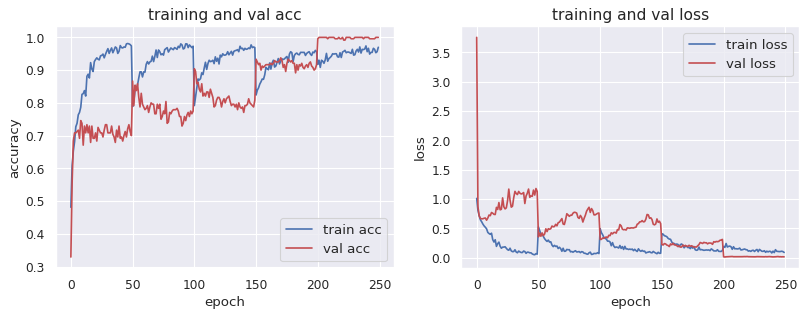

In [57]:
import seaborn as sns
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(CFG.N_EPOCHS*5):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i]
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = CFG.N_EPOCHS

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs*5), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs*5), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs*5), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs*5), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [58]:
test_eval(model_ft)

  0%|          | 0/9 [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same